In [144]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
from fradm.tn_test import *
import matplotlib.pyplot as plt
from ncon import ncon

In [146]:
L = 7
chi = 8
chain = Z2_chain_massive_mps(L=L, d=2, chi=chi, J=1, h1=0.1, h2=0.1)
chain._random_state(seed=3, chi=chi)
chain.canonical_form()
chain.DMRG(trunc_tol=False, trunc_chi=True)
# chain.DMRG(trunc_tol=True, trunc_chi=False)
tensor_shapes(chain.sites)
Z = np.array([[1,0],[0,-1]])
Z = np.array([[1,0],[0,-1]])
exp_vals = []
for i in range(L):
    chain.local_order_param(site=i)
    occup = chain.mpo_first_moment().real
    exp_vals.append(occup)

Sweep n: 0

Sweep n: 1

##############################
The energy between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 2
total iterations 13
total time: 0.0767373830312863
##############################
(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)


In [51]:
occup_state = np.array([0,1]).reshape((1,2,1))
vacuum_state = np.array([1,0]).reshape((1,2,1))
vacuum_tensor = [vacuum_state for _ in range(L)]
vacuum_tensor[L//2] = occup_state
vacuum_tensor[L//2-1] = occup_state
vacuum_tensor[L//2+1] = occup_state
perturbed_tensor = vacuum_tensor

In [59]:
chi = 8
chain = Z2_chain_massive_mps(L=L, d=2, chi=chi, J=1, h1=0.1, h2=0.1)
chain.sites = perturbed_tensor
chain.enlarge_chi();

In [60]:
params_quench = dict(trotter_steps = 100,
        delta = 0.1,
        n_sweeps = 8,
        conv_tol = 1e-10,
        bond = True,
        where = -1)
errs, entrs, smvs = chain.TEBD_Z2_chain(params_quench=params_quench)

------ Trotter steps: 0 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 6
total iterations 13
##############################
------ Trotter steps: 1 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 6
total iterations 13
##############################
------ Trotter steps: 2 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 6
total iterations 13
##############################
------ Trotter steps: 3 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated sta

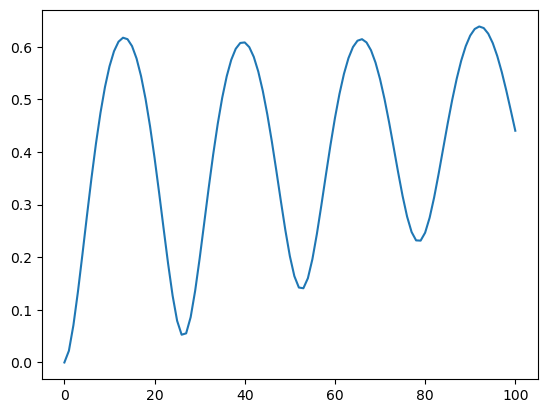

In [61]:
plt.plot(entrs)

------ Trotter steps: 0 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 22
total iterations 45
##############################


/Users/fradm98/opt/anaconda3/envs/qs_qh/lib/python3.12/site-packages/qs_mps/utils.py:379: RuntimeWarning: divide by zero encountered in log2
  return -np.sum((s**2) * np.log2(s**2))
/Users/fradm98/opt/anaconda3/envs/qs_qh/lib/python3.12/site-packages/qs_mps/utils.py:379: RuntimeWarning: invalid value encountered in multiply
  return -np.sum((s**2) * np.log2(s**2))


------ Trotter steps: 1 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 22
total iterations 45
##############################
------ Trotter steps: 2 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 22
total iterations 45
##############################
------ Trotter steps: 3 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated states converged
to an order of 1e-10 after:
1 sweeps at site 22
total iterations 45
##############################
------ Trotter steps: 4 -------
Bond dim ancilla: 8
Bond dim site: 8
Sweep n: 0

Sweep n: 1

##############################
The error between the two last updated 

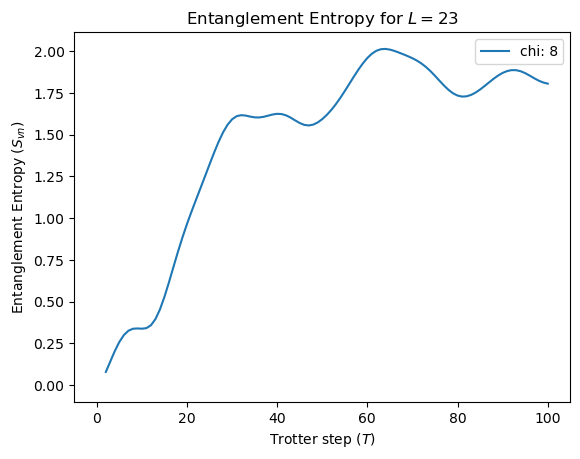

In [185]:
chis = [8]
L = 23
occup_state = np.array([0,1]).reshape((1,2,1))
vacuum_state = np.array([1,0]).reshape((1,2,1))
vacuum_tensor = [vacuum_state for _ in range(L)]
vacuum_tensor[L//2] = occup_state
vacuum_tensor[L//2-1] = occup_state
vacuum_tensor[L//2+1] = occup_state
perturbed_tensor = vacuum_tensor
for chi in chis:
        chain = Z2_chain_massive_mps(L=L, d=2, chi=chi, J=1, h1=0.05, h2=0.5)
        chain.sites = perturbed_tensor
        chain.enlarge_chi()
        params_quench = dict(trotter_steps = 100,
                delta = 0.1,
                n_sweeps = 8,
                conv_tol = 1e-10,
                bond = True,
                where = -1)
        errs, entrs, smvs, evs = chain.TEBD_Z2_chain(params_quench=params_quench)
        plt.plot(entrs, label=f"chi: {chi}")
        # plt.matshow((1-evs)/2, cmap='inferno', aspect=0.5, vmin=0, vmax=1)

plt.title("Entanglement Entropy for $L=$"+f"${L}$")
plt.xlabel("Trotter step $(T)$")
plt.ylabel("Entanglement Entropy $(S_{vn})$")
plt.legend()

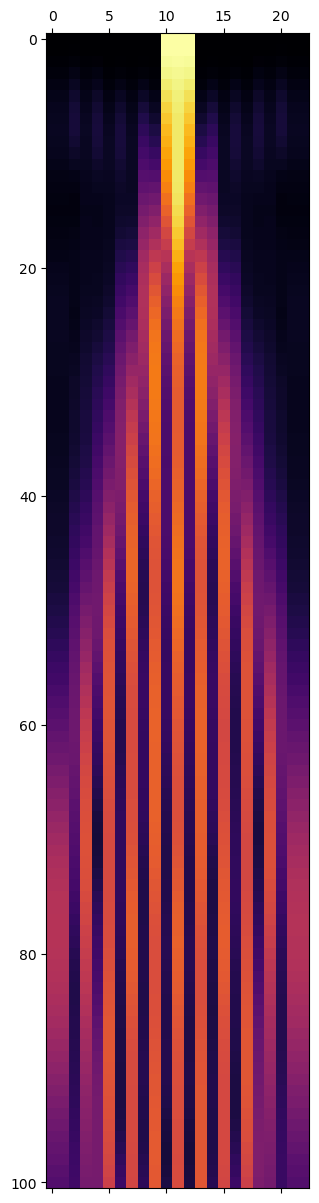

In [196]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.matshow((1-evs)/2, cmap='inferno', vmin=0, vmax=1)

## Construct MPO

We define three mpos for the mass and gauge sites, we have to use them to find a single mpo for the bulk of the chain and the boundaries

### Exact terms

In [182]:
def interaction_term(L):
    int = np.zeros((2**L,2**L))
    for i in range(0,L-2,2):
        int += linalg.expm(1j*np.pi/4*(sparse_pauli_x(n=i,L=L) @ sparse_pauli_x(n=i+1,L=L) @ sparse_pauli_x(n=i+2,L=L)))

    return int

int_term_trott = interaction_term(7)
res, _ = pauli_decomposition(int_term_trott)
[(_[i][0],_[i][1]) for i in range(len(_)) if round(_[i][0],10) != 0]

/var/folders/32/fk_0xqj113d4fp2cxfpqtfd40000gr/T/ipykernel_17455/507019043.py:10: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  [(_[i][0],_[i][1]) for i in range(len(_)) if round(_[i][0],10) != 0]


[((2.1213203435596424+0j), 'IIIIIII'),
 (0.7071067811865476j, 'IIIIXXX'),
 (0.7071067811865476j, 'IIXXXII'),
 (0.7071067811865476j, 'XXXIIII')]

In [192]:
theta = np.pi/4
I = identity(2).toarray()
O = np.zeros((2,2))
X = sparse_pauli_x(0,1).toarray()
w_start = np.asarray([(np.cos(theta))**(1/3)*I, (np.sin(theta))**(1/3)*X]).reshape((1,2,2,2))
w_middle = np.asarray([[(np.cos(theta))**(1/3)*I, O],[O, (np.sin(theta))**(1/3)*X]])
w_end = np.asarray([(np.cos(theta))**(1/3)*I, 1j*(np.sin(theta))**(1/3)*X]).reshape((2,1,2,2))
print(np.cos(theta)**(1/3)*np.sin(theta)**(1/3),np.cos(theta)**(2/3),np.sin(theta)**(2/3))

0.7937005259840998 0.7937005259840998 0.7937005259840997


In [149]:
w_1_l = w_start
w_2_l = ncon([w_start,w_middle],[[-1,-3,-5,1],[-2,-4,1,-6]]).reshape((2,4,2,2))
w_1_r = w_end
w_2_r = ncon([w_middle,w_end],[[-1,-3,-5,1],[-2,-4,1,-6]]).reshape((4,2,2,2))
print(w_1_l,w_2_l,w_1_r,w_2_r)

[[[[0.89089872 0.        ]
   [0.         0.89089872]]

  [[0.         0.89089872]
   [0.89089872 0.        ]]]] [[[[0.79370053 0.        ]
   [0.         0.79370053]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.79370053]
   [0.79370053 0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]]


 [[[0.         0.        ]
   [0.         0.        ]]

  [[0.         0.79370053]
   [0.79370053 0.        ]]

  [[0.         0.        ]
   [0.         0.        ]]

  [[0.79370053 0.        ]
   [0.         0.79370053]]]] [[[[0.89089872+0.j         0.        +0.j        ]
   [0.        +0.j         0.89089872+0.j        ]]]


 [[[0.        +0.j         0.        +0.89089872j]
   [0.        +0.89089872j 0.        +0.j        ]]]] [[[[0.79370053+0.j         0.        +0.j        ]
   [0.        +0.j         0.79370053+0.j        ]]

  [[0.        +0.j         0.        +0.j        ]
   [0.        +0.j         0.        +0.j        ]]]


 [[[0.        +

In [190]:
w_b_1 = ncon([w_start,w_end],[[-1,-3,-5,1],[-2,-4,1,-6]]).reshape((2,2,2,2))

In [197]:
v_l = np.array([1])
v_r = v_l
mat = ncon([v_l,w_start,w_middle,w_b_1,w_middle,w_b_1,w_middle,w_end,v_r],[[1],[1,2,-1,-8],[2,3,-2,-9],[3,4,-3,-10],[4,5,-4,-11],[5,6,-5,-12],[6,7,-6,-13],[7,8,-7,-14],[8]])
mat = mat.reshape((2**7,2**7))
res, _ = pauli_decomposition(mat)
[(_[i][0],_[i][1]) for i in range(len(_)) if round(_[i][0],10) != 0]

/var/folders/32/fk_0xqj113d4fp2cxfpqtfd40000gr/T/ipykernel_17455/4261616330.py:6: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  [(_[i][0],_[i][1]) for i in range(len(_)) if round(_[i][0],10) != 0]


[((0.353553390593274+0j), 'IIIIIII'),
 (0.3535533905932739j, 'IIIIXXX'),
 ((-0.3535533905932739+0j), 'IIXXIXX'),
 (0.35355339059327395j, 'IIXXXII'),
 (-0.3535533905932737j, 'XXIXIXX'),
 ((-0.3535533905932739+0j), 'XXIXXII'),
 (0.3535533905932739j, 'XXXIIII'),
 ((-0.3535533905932739+0j), 'XXXIXXX')]

In [152]:
mat = ncon([v_l,w_start,w_middle,w_end,v_r],[[1],[1,2,-1,-4],[2,3,-2,-5],[3,4,-3,-6],[4]]).reshape((8,8))
res, _ = pauli_decomposition(mat)
[(_[i][0],_[i][1]) for i in range(len(_)) if _[i][0] != 0]

[((0.7071067811865477+0j), 'III'), (0.7071067811865475j, 'XXX')]

We can visualize it with `sympy`

In [ ]:
from sympy import *
theta, I, O, X, i = symbols('θ I O X i')

In [ ]:
w_l1 = Matrix([[(cos(theta))**(S(1)/3)* I, (sin(theta))**(S(1)/3)*X]])
w_l2 = Matrix([[(cos(theta))**(S(2)/3)* I, O, (sin(theta)*cos(theta))**(S(1)/3)*X, O],[O, (sin(theta)*cos(theta))**(S(1)/3)*X, O, (sin(theta))**(S(2)/3)*I]])
w_r1 = Matrix([[(cos(theta))**(S(1)/3)* I],[-i*(sin(theta))**(S(1)/3)*X]])
w_r2 = Matrix([[(cos(theta))**(S(2)/3)* I, O],
                [-i*(sin(theta)*cos(theta))**(S(1)/3)*X, O],
                [O, (sin(theta)*cos(theta))**(S(1)/3)*X],
                [O, -(sin(theta))**(S(2)/3)*I]])

In [ ]:
display(w_l1,w_l2,w_r1,w_r2)